In [1]:
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from IPython.display import display_html
from sklearn.utils import estimator_html_repr

from dbpedia_common import DataFrameRepository, get_single_stratified_split
from anomalies_analyser import compare_population_with_web
from models import get_lxgb_pipeline, ModelEvaluator

%matplotlib inline
train_df = DataFrameRepository(version='last').get()

In [6]:
display_html(estimator_html_repr(get_lxgb_pipeline()), raw=True)

Pipeline Pipeline(steps=[('calculated_pop', CalculatedPopTransformer()),
 ('categorical_transformer',
 Pipeline(steps=[('set_as_category',
 FunctionTransformer(func= .set_as_category at 0x7f8113bf65f0>))])),
 ('rename_columns',
 Pipeline(steps=[('rename_columns',
 FunctionTransformer(func= .rename_cols at 0x7f8113bf6a70>))])),
 ('model',
 LGBMRegressor(bagging_freq=20, cat_smooth=1,
 feature_fraction=0.4, learning_rate=0.03,
 max_depth=7, n_estimators=1500, num_leaves=20,
 reg_alpha=0.8))]) CalculatedPopTransformer CalculatedPopTransformer() categorical_transformer: Pipeline Pipeline(steps=[('set_as_category',
 FunctionTransformer(func= .set_as_category at 0x7f8113bf65f0>))]) FunctionTransformer FunctionTransformer(func= .set_as_category at 0x7f8113bf65f0>) rename_columns: Pipeline Pipeline(steps=[('rename_columns',
 FunctionTransformer(func= .rename_cols at 0x7f8113bf6a70>))]) FunctionTransformer FunctionTransformer(func= .rename_cols at 0x7f8113bf6a70>) LGBMRegressor LGBMRegressor(bagging_freq=20, cat_smooth=1, feature_fraction=0.4,
 learning_rate=0.03, max_depth=7, n_estimators=1500, num_leaves=20,
 reg_alpha=0.8)

********************
Test RMSLE: 0.26630210352882694
Test RMSE: 255560.30129083854
********************
Train RMSLE: 0.2412206467094599
Train RMSE: 208215.87064305824


,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
21842,Merkezefendi>,-1.584,5.420,3.835,262825.000,6843.671,-255981.329,<http://dbpedia.org/resource/Merkezefendi>
18243,Kungsholmen_(borough)>,-1.416,4.833,3.417,68016.000,2611.358,-65404.642,<http://dbpedia.org/resource/Kungsholmen_(boro...
23970,New_Delhi>,1.354,5.411,6.765,257803.000,5827469.022,5569666.022,<http://dbpedia.org/resource/New_Delhi>
1926,Ba'a>,1.323,3.065,4.388,1161.000,24444.632,23283.632,<http://dbpedia.org/resource/Ba'a>
4574,"Bret_Harte,_California>",-1.274,4.712,3.438,51481.000,2740.302,-48740.698,"<http://dbpedia.org/resource/Bret_Harte,_Calif..."
...,...,...,...,...,...,...,...,...
22735,"Moosic,_Pennsylvania>",-0.000,3.757,3.757,5719.000,5717.733,-1.267,"<http://dbpedia.org/resource/Moosic,_Pennsylva..."
36587,Vitória_da_Conquista>,-0.000,5.539,5.539,346069.000,346002.737,-66.263,<http://dbpedia.org/resource/Vitória_da_Conqui...
19143,"Lavonia,_Georgia>",-0.000,3.334,3.334,2156.000,2155.658,-0.342,"<http://dbpedia.org/resource/Lavonia,_Georgia>"
19633,"Lincolnville,_South_Carolina>",-0.000,3.057,3.057,1139.000,1138.968,-0.032,"<http://dbpedia.org/resource/Lincolnville,_Sou..."


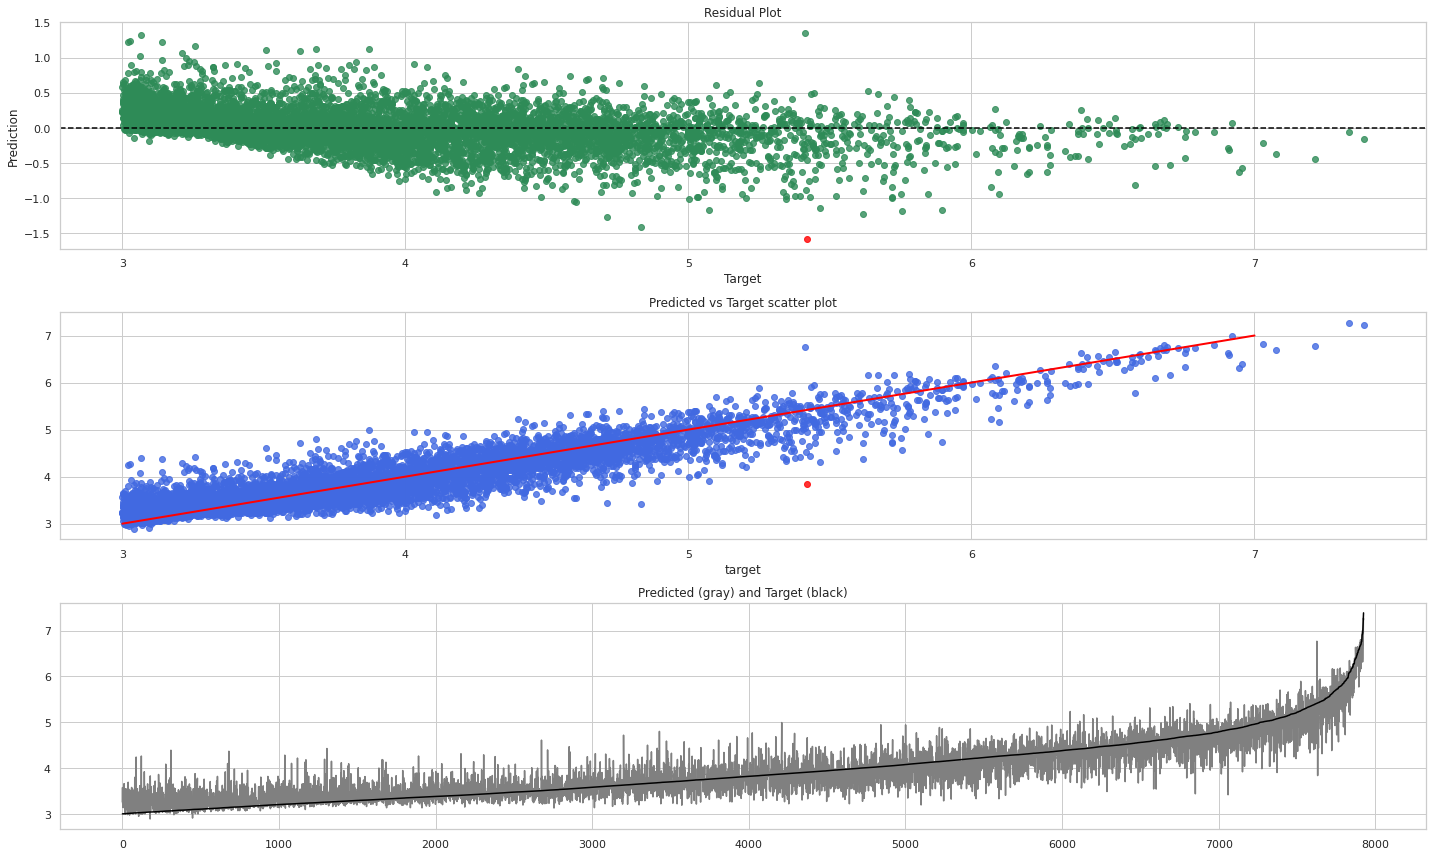

In [167]:
train_index, test_index = get_single_stratified_split(train_df)

X = train_df.drop(columns=['subject', 'target'])
y = np.log10(train_df.target)


X_train, y_train = X.loc[train_index], y.loc[train_index]
y_test = y.loc[test_index].sort_values()
X_test = X.loc[test_index].reindex(y_test.index)


model = TransformedTargetRegressor(regressor=get_lxgb_pipeline(), transformer=MinMaxScaler())
model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=False)
evaluator.plot_results()
error_analysis_df = evaluator.get_error_analysis(train_df)
error_analysis_df

In [168]:
compare_population_with_web(error_analysis_df, limit=10).head(10)

0 Errors found while parsing wikipedia webpage. Make a manual check for: []
There are 0 suspicious subjects! Check if found values are real and fix the records


,pretty_subject,error,expected_value,found_value,relative_log_diff,message,wiki_link,subject
0,Merkezefendi,False,262825.000,262825,0.000,,https://en.wikipedia.org/wiki/Merkezefendi,<http://dbpedia.org/resource/Merkezefendi>
1,Kungsholmen_(borough),False,68016.000,68016,0.000,,https://en.wikipedia.org/wiki/Kungsholmen_%28b...,<http://dbpedia.org/resource/Kungsholmen_(boro...
2,New_Delhi,False,257803.000,257803,0.000,,https://en.wikipedia.org/wiki/New_Delhi,<http://dbpedia.org/resource/New_Delhi>
3,Ba'a,False,1161.000,1161,0.000,,https://en.wikipedia.org/wiki/Ba%27a,<http://dbpedia.org/resource/Ba'a>
4,"Bret_Harte,_California",False,51481.000,51481,0.000,,https://en.wikipedia.org/wiki/Bret_Harte%2C_Ca...,"<http://dbpedia.org/resource/Bret_Harte,_Calif..."
5,Province_of_Mantua,False,413663.000,413663,0.000,,https://en.wikipedia.org/wiki/Province_of_Mantua,<http://dbpedia.org/resource/Province_of_Mantua>
6,"The_Valley,_Anguilla",False,1067.000,1067,0.000,,https://en.wikipedia.org/wiki/The_Valley%2C_An...,"<http://dbpedia.org/resource/The_Valley,_Angui..."
7,As_Somozas,False,1382.000,1382,0.000,,https://en.wikipedia.org/wiki/As_Somozas,<http://dbpedia.org/resource/As_Somozas>
8,"Hagåtña,_Guam",False,1051.000,1051,0.000,,https://en.wikipedia.org/wiki/Hag%C3%A5t%C3%B1...,"<http://dbpedia.org/resource/Hagåtña,_Guam>"
9,Aparecida_de_Goiânia,False,565957.000,565957,0.000,,https://en.wikipedia.org/wiki/Aparecida_de_Goi...,<http://dbpedia.org/resource/Aparecida_de_Goiâ...


### Trying splitting target in bins

In [72]:
df = train_df.copy()
bins = [0,2499, 4999, 9999, 49999, 99999, 499_999, 999_999, np.inf]
label_bins = [0, 1, 2 ,3, 4, 5, 6, 7]
df['target'] = pd.cut(df['target'], bins=bins, labels=label_bins).astype(int)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_index, test_index = next(split.split(df, df['target']))

X = train_df.drop(columns=['subject', 'target'])
y = np.log10(train_df.target)

X_train, y_train = X.loc[train_index], y.loc[train_index]
y_test = y.loc[test_index]
X_test = X.loc[test_index]

model = TransformedTargetRegressor(regressor=get_lxgb_pipeline(), transformer=MinMaxScaler())
model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(log=False)

r = pd.cut(10**test_pred, bins=bins, labels=label_bins).astype(int)

y_test_r=pd.cut(10**y_test, bins=bins, labels=label_bins).astype(int)

print(f'Quadratic Kappa Score: {cohen_kappa_score(y_test_r, r, weights="quadratic")}')
confusion_matrix(y_test_r, r, labels=label_bins)

Quadratic Kappa Score: 0.8866730566276324


array([[1985,  947,  150,   34,    1,    0,    0,    0],
       [ 359, 1347,  352,   81,    2,    1,    0,    0],
       [  65,  541,  888,  325,    5,    2,    0,    0],
       [   6,  189,  487, 2274,  173,   22,    0,    0],
       [   0,    3,   11,  299,  292,   68,    1,    0],
       [   0,    0,    4,   87,  162,  417,   33,    5],
       [   0,    0,    0,    1,    4,   61,   42,   15],
       [   0,    0,    0,    1,    0,   12,   30,  105]])